Clock cycle 1:
  Inputs:
    A: 0b00000001 (1)
    B: 0b00000010 (2)
    Opcode: 0b000 (ADD)
  Results:
    ALU Result: 0b00000011 (3)
    Q Output: 0b00000000 (0)
  Flags:
    Carry: 0
    Zero: 0
  States: [0, 0, 0, 0, 0, 0, 0, 0]

Clock cycle 2:
  Inputs:
    A: 0b11111111 (255)
    B: 0b00000010 (2)
    Opcode: 0b000 (ADD)
  Results:
    ALU Result: 0b00000001 (1)
    Q Output: 0b00000011 (3)
  Flags:
    Carry: 1
    Zero: 0
  States: [1, 1, 0, 0, 0, 0, 0, 0]

Clock cycle 3:
  Inputs:
    A: 0b11111111 (255)
    B: 0b11111111 (255)
    Opcode: 0b000 (ADD)
  Results:
    ALU Result: 0b11111110 (254)
    Q Output: 0b00000001 (1)
  Flags:
    Carry: 1
    Zero: 0
  States: [1, 0, 0, 0, 0, 0, 0, 0]

Clock cycle 4:
  Inputs:
    A: 0b00000000 (0)
    B: 0b11111111 (255)
    Opcode: 0b101 (SHL)
  Results:
    ALU Result: 0b11111110 (254)
    Q Output: 0b11111110 (254)
  Flags:
    Carry: 1
    Zero: 0
  States: [0, 1, 1, 1, 1, 1, 1, 1]

Clock cycle 5:
  Inputs:
    A: 0b00000000 (0)
   

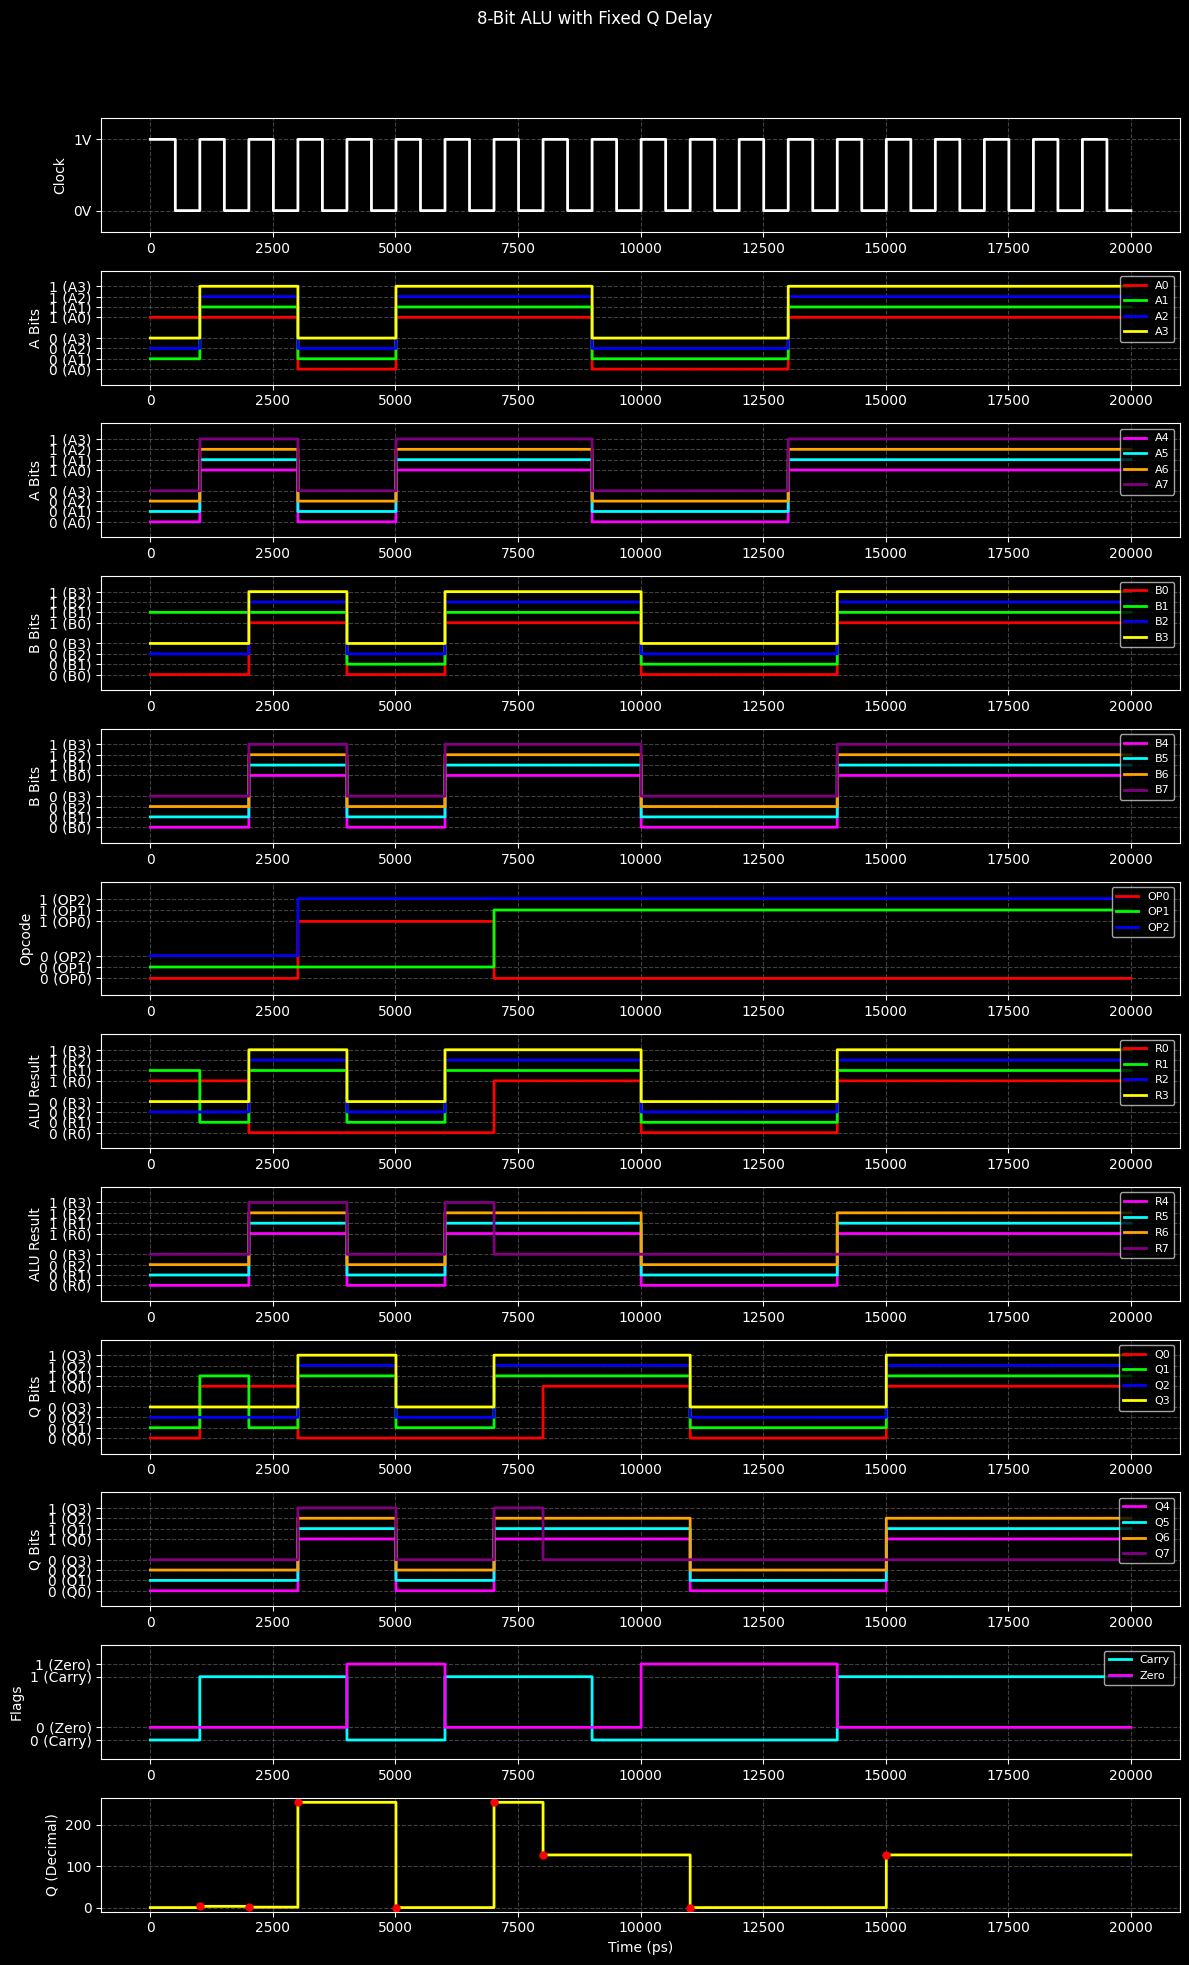

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
CLOCK_PERIOD = 1000e-12
STEP_SIZE = 10e-12

# Discrete gate functions
def not_gate(a):
    return 1 if a == 0 else 0

def and_gate(a, b):
    return 1 if a == 1 and b == 1 else 0

def or_gate(a, b):
    return 1 if a == 1 or b == 1 else 0

def xor_gate(a, b):
    return 1 if a != b else 0

def nor_gate(a, b):
    return not_gate(or_gate(a, b))

# 1-bit ALU
def alu_1bit(a, b, cin, opcode, prev_b=None, next_b=None, bit_index=0):
    op0, op1, op2 = opcode[0], opcode[1], opcode[2]
    
    b_sub = xor_gate(b, op0)
    sum_xor1 = xor_gate(a, b_sub)
    result_add = xor_gate(sum_xor1, cin)
    carry1 = and_gate(a, b_sub)
    carry2 = and_gate(sum_xor1, cin)
    cout_add_sub = or_gate(carry1, carry2)
    
    result_sub = result_add
    result_and = and_gate(a, b)
    result_or = or_gate(a, b)
    result_xor = xor_gate(a, b)
    
    if op0 == 1 and op1 == 0 and op2 == 1:  # 0b101
        result_shl = prev_b if bit_index > 0 else cin
        cout_shl = b if bit_index == 7 else cout_add_sub
    else:
        result_shl = 0
        cout_shl = cout_add_sub
    
    if op0 == 0 and op1 == 1 and op2 == 1:  # 0b110
        result_shr = next_b if bit_index < 7 else cin
        cout_shr = b if bit_index == 0 else cout_add_sub
    else:
        result_shr = 0
        cout_shr = cout_add_sub
    
    sel_add = and_gate(and_gate(not_gate(op2), not_gate(op1)), not_gate(op0))
    sel_sub = and_gate(and_gate(not_gate(op2), not_gate(op1)), op0)
    sel_and = and_gate(and_gate(not_gate(op2), op1), not_gate(op0))
    sel_or = and_gate(and_gate(not_gate(op2), op1), op0)
    sel_xor = and_gate(and_gate(op2, not_gate(op1)), not_gate(op0))
    sel_shl = and_gate(and_gate(op2, not_gate(op1)), op0)
    sel_shr = and_gate(and_gate(op2, op1), not_gate(op0))
    
    result = or_gate(or_gate(or_gate(or_gate(or_gate(or_gate(
        and_gate(result_add, sel_add),
        and_gate(result_sub, sel_sub)),
        and_gate(result_and, sel_and)),
        and_gate(result_or, sel_or)),
        and_gate(result_xor, sel_xor)),
        and_gate(result_shl, sel_shl)),
        and_gate(result_shr, sel_shr))
    
    cout = cout_shl if sel_shl == 1 else (cout_shr if sel_shr == 1 else cout_add_sub)
    
    return result, cout

# 8-bit ALU
def alu_8bit(A, B, opcode):
    result = []
    cout = 0
    for i in range(8):
        prev_b = B[i-1] if i > 0 else 0
        next_b = B[i+1] if i < 7 else 0
        cin = 0 if (i == 7 and opcode == [0, 1, 1]) else cout
        res, cout = alu_1bit(A[i], B[i], cin, opcode, prev_b, next_b, i)
        result.append(res)
    zero = 0 if any(res == 1 for res in result) else 1
    return result, cout, zero

# Digital SR Latch
def sr_latch_update(S, R, Q, Q_bar):
    if S == 1 and R == 1:
        return Q, Q_bar
    elif S == 1:
        return 1, 0
    elif R == 1:
        return 0, 1
    else:
        return Q, Q_bar

# 8-bit D Flip-Flop with proper delay
def d_flip_flop_8bit_update(D_bits, clock, states):
    Q_bits = []
    Q_bar_bits = []
    for i in range(8):
        Qm = states[i].get('Qm', 0)
        Qm_bar = states[i].get('Qm_bar', 1)
        Q = states[i].get('Q', 0)
        Q_bar = states[i].get('Q_bar', 1)
        prev_clock = states[i].get('prev_clock', 0)

        rising_edge = clock == 1 and prev_clock == 0

        if rising_edge:
            Sm = D_bits[i]
            Rm = not_gate(D_bits[i])
            Qm, Qm_bar = sr_latch_update(Sm, Rm, Qm, Qm_bar)
            Ss = Qm
            Rs = not_gate(Qm)
            states[i]['Q'], states[i]['Q_bar'] = sr_latch_update(Ss, Rs, Q, Q_bar)

        states[i]['Qm'] = Qm
        states[i]['Qm_bar'] = Qm_bar
        states[i]['prev_clock'] = clock
        Q_bits.append(states[i]['Q'])  # Use stored Q (previous cycle's D)
        Q_bar_bits.append(states[i]['Q_bar'])
    
    return Q_bits, Q_bar_bits, states

# Helper: Binary string to bit list (LSB first)
def int_to_bits(binary_str):
    if not binary_str.startswith('0b') or len(binary_str) != 10 or not all(c in '01' for c in binary_str[2:]):
        raise ValueError(f"Invalid binary string for 8-bit input: {binary_str}. Expected '0b' + 8 bits.")
    return [int(c) for c in binary_str[2:]][::-1]

# Helper: Opcode binary string to bit list (3 bits, LSB first)
def opcode_to_bits(binary_str):
    if not binary_str.startswith('0b') or len(binary_str) != 5 or not all(c in '01' for c in binary_str[2:]):
        raise ValueError(f"Invalid binary string for opcode: {binary_str}. Expected '0b' + 3 bits.")
    return [int(c) for c in binary_str[2:]][::-1]

# Helper: Bits to binary string for debug output
def bits_to_binary_string(bits, length=8):
    return f"0b{''.join(str(int(bit)) for bit in bits[::-1][:length])}"

# Helper: Opcode to operation name
def opcode_to_name(opcode):
    op_map = {
        (0, 0, 0): "ADD",
        (1, 0, 0): "SUB",
        (0, 1, 0): "AND",
        (1, 1, 0): "OR",
        (0, 0, 1): "XOR",
        (1, 0, 1): "SHL",
        (0, 1, 1): "SHR"
    }
    return op_map.get(tuple(opcode), "UNKNOWN")

# Simulate 8-bit ALU with D Flip-Flop
def simulate_alu_8bit(A_changes, B_changes, opcode_changes, num_cycles=20):
    total_time = num_cycles * CLOCK_PERIOD
    time_steps = np.arange(0, total_time, STEP_SIZE)
    states = [{'Qm': 0, 'Qm_bar': 1, 'Q': 0, 'Q_bar': 1, 'prev_clock': 0} for _ in range(8)]
    
    A_values = [[] for _ in range(8)]
    B_values = [[] for _ in range(8)]
    opcode_values = [[] for _ in range(3)]
    alu_result_values = [[] for _ in range(8)]
    Q_values = [[] for _ in range(8)]
    clock_values = []
    carry_values = []
    zero_values = []
    
    current_A = int_to_bits(A_changes[0][1] if A_changes else '0b00000000')
    current_B = int_to_bits(B_changes[0][1] if B_changes else '0b00000000')
    current_opcode = opcode_to_bits(opcode_changes[0][1] if opcode_changes else '0b000')
    clock_count = 0
    A_index = 0
    B_index = 0
    opcode_index = 0
    prev_alu_result = [0] * 8  # Store previous cycle's ALU result
    
    for t in time_steps:
        clock = 1 if (t % CLOCK_PERIOD) < (CLOCK_PERIOD / 2) else 0
        
        if clock == 1 and states[0]['prev_clock'] == 0:  # Rising edge
            clock_count += 1
            while A_index < len(A_changes) and A_changes[A_index][0] <= clock_count:
                current_A = int_to_bits(A_changes[A_index][1])
                A_index += 1
            while B_index < len(B_changes) and B_changes[B_index][0] <= clock_count:
                current_B = int_to_bits(B_changes[B_index][1])
                B_index += 1
            while opcode_index < len(opcode_changes) and opcode_changes[opcode_index][0] <= clock_count:
                current_opcode = opcode_to_bits(opcode_changes[opcode_index][1])
                opcode_index += 1
            
            A_bits = current_A
            B_bits = current_B
            opcode = current_opcode
            
            alu_result, carry, zero = alu_8bit(A_bits, B_bits, opcode)
            Q_bits, Q_bar_bits, states = d_flip_flop_8bit_update(prev_alu_result, clock, states)  # Use previous ALU result
            
            A_binary = bits_to_binary_string(A_bits)
            B_binary = bits_to_binary_string(B_bits)
            opcode_binary = bits_to_binary_string(opcode, 3)
            A_decimal = sum(bit * (2**i) for i, bit in enumerate(A_bits))
            B_decimal = sum(bit * (2**i) for i, bit in enumerate(B_bits))
            result_binary = bits_to_binary_string(alu_result)
            Q_binary = bits_to_binary_string(Q_bits)
            result_decimal = sum(bit * (2**i) for i, bit in enumerate(alu_result))
            Q_decimal = sum(bit * (2**i) for i, bit in enumerate(Q_bits))
            
            print(f"Clock cycle {clock_count}:")
            print(f"  Inputs:")
            print(f"    A: {A_binary} ({A_decimal})")
            print(f"    B: {B_binary} ({B_decimal})")
            print(f"    Opcode: {opcode_binary} ({opcode_to_name(opcode)})")
            print(f"  Results:")
            print(f"    ALU Result: {result_binary} ({result_decimal})")
            print(f"    Q Output: {Q_binary} ({Q_decimal})")
            print(f"  Flags:")
            print(f"    Carry: {carry}")
            print(f"    Zero: {zero}")
            print(f"  States: {[states[i]['Q'] for i in range(8)]}")
            print()
            
            prev_alu_result = alu_result  # Store current ALU result for next cycle
        
        else:
            A_bits = current_A
            B_bits = current_B
            opcode = current_opcode
            alu_result, carry, zero = alu_8bit(A_bits, B_bits, opcode)
            Q_bits, Q_bar_bits, states = d_flip_flop_8bit_update(prev_alu_result, clock, states)
        
        for i in range(8):
            A_values[i].append(A_bits[i])
            B_values[i].append(B_bits[i])
            alu_result_values[i].append(alu_result[i])
            Q_values[i].append(Q_bits[i])
        for i in range(3):
            opcode_values[i].append(opcode[i])
        clock_values.append(clock)
        carry_values.append(carry)
        zero_values.append(zero)
    
    return time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values

# Visualize with offset to prevent overlap
def plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, 
                     carry_values, zero_values):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 20))
    
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080']
    offset = 0.2
    
    ax_clock = fig.add_subplot(12, 1, 1)
    ax_clock.step(time_steps * 1e12, clock_values, where='post', color='white', linewidth=2)
    ax_clock.set_ylabel('Clock', color='white', fontsize=10)
    ax_clock.set_ylim(-0.3, 1.3)
    ax_clock.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_clock.set_yticks([0, 1])
    ax_clock.set_yticklabels(['0V', '1V'], color='white')
    
    axes_A = [fig.add_subplot(12, 1, i+2) for i in range(2)]
    for i in range(8):
        ax_A = axes_A[i // 4]
        offset_values = [v + (i % 4) * offset for v in A_values[i]]
        ax_A.step(time_steps * 1e12, offset_values, where='post', color=colors[i], linewidth=2, label=f'A{i}')
        ax_A.set_ylim(-0.3, 1.3 + 3 * offset)
        ax_A.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax_A.set_yticks([j * offset for j in range(4)] + [1 + j * offset for j in range(4)])
        ax_A.set_yticklabels([f'0 (A{j})' for j in range(4)] + [f'1 (A{j})' for j in range(4)], color='white')
        ax_A.legend(loc='upper right', fontsize=8, labelcolor='white')
        ax_A.set_ylabel('A Bits', color='white', fontsize=10)
    
    axes_B = [fig.add_subplot(12, 1, i+4) for i in range(2)]
    for i in range(8):
        ax_B = axes_B[i // 4]
        offset_values = [v + (i % 4) * offset for v in B_values[i]]
        ax_B.step(time_steps * 1e12, offset_values, where='post', color=colors[i], linewidth=2, label=f'B{i}')
        ax_B.set_ylim(-0.3, 1.3 + 3 * offset)
        ax_B.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax_B.set_yticks([j * offset for j in range(4)] + [1 + j * offset for j in range(4)])
        ax_B.set_yticklabels([f'0 (B{j})' for j in range(4)] + [f'1 (B{j})' for j in range(4)], color='white')
        ax_B.legend(loc='upper right', fontsize=8, labelcolor='white')
        ax_B.set_ylabel('B Bits', color='white', fontsize=10)
    
    ax_opcode = fig.add_subplot(12, 1, 6)
    for i in range(3):
        offset_values = [v + i * offset for v in opcode_values[i]]
        ax_opcode.step(time_steps * 1e12, offset_values, where='post', color=colors[i], linewidth=2, label=f'OP{i}')
    ax_opcode.set_ylabel('Opcode', color='white', fontsize=10)
    ax_opcode.set_ylim(-0.3, 1.3 + 2 * offset)
    ax_opcode.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_opcode.set_yticks([i * offset for i in range(3)] + [1 + i * offset for i in range(3)])
    ax_opcode.set_yticklabels([f'0 (OP{i})' for i in range(3)] + [f'1 (OP{i})' for i in range(3)], color='white')
    ax_opcode.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    axes_result = [fig.add_subplot(12, 1, i+7) for i in range(2)]
    for i in range(8):
        ax_result = axes_result[i // 4]
        offset_values = [v + (i % 4) * offset for v in alu_result_values[i]]
        ax_result.step(time_steps * 1e12, offset_values, where='post', color=colors[i], linewidth=2, label=f'R{i}')
        ax_result.set_ylim(-0.3, 1.3 + 3 * offset)
        ax_result.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax_result.set_yticks([j * offset for j in range(4)] + [1 + j * offset for j in range(4)])
        ax_result.set_yticklabels([f'0 (R{j})' for j in range(4)] + [f'1 (R{j})' for j in range(4)], color='white')
        ax_result.legend(loc='upper right', fontsize=8, labelcolor='white')
        ax_result.set_ylabel('ALU Result', color='white', fontsize=10)
    
    axes_Q = [fig.add_subplot(12, 1, i+9) for i in range(2)]
    for i in range(8):
        ax_Q = axes_Q[i // 4]
        offset_values = [v + (i % 4) * offset for v in Q_values[i]]
        ax_Q.step(time_steps * 1e12, offset_values, where='post', color=colors[i], linewidth=2, label=f'Q{i}')
        ax_Q.set_ylim(-0.3, 1.3 + 3 * offset)
        ax_Q.grid(True, color='gray', linestyle='--', alpha=0.5)
        ax_Q.set_yticks([j * offset for j in range(4)] + [1 + j * offset for j in range(4)])
        ax_Q.set_yticklabels([f'0 (Q{j})' for j in range(4)] + [f'1 (Q{j})' for j in range(4)], color='white')
        ax_Q.legend(loc='upper right', fontsize=8, labelcolor='white')
        ax_Q.set_ylabel('Q Bits', color='white', fontsize=10)
    
    ax_flags = fig.add_subplot(12, 1, 11)
    ax_flags.step(time_steps * 1e12, [v + 0 * offset for v in carry_values], where='post', color='cyan', linewidth=2, label='Carry')
    ax_flags.step(time_steps * 1e12, [v + 1 * offset for v in zero_values], where='post', color='magenta', linewidth=2, label='Zero')
    ax_flags.set_ylabel('Flags', color='white', fontsize=10)
    ax_flags.set_ylim(-0.3, 1.3 + 1 * offset)
    ax_flags.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_flags.set_yticks([0, offset, 1, 1 + offset])
    ax_flags.set_yticklabels(['0 (Carry)', '0 (Zero)', '1 (Carry)', '1 (Zero)'], color='white')
    ax_flags.legend(loc='upper right', fontsize=8, labelcolor='white')
    
    Q_decimal = [sum(Q_values[i][j] * (2**i) for i in range(8)) for j in range(len(time_steps))]
    ax_decimal = fig.add_subplot(12, 1, 12)
    ax_decimal.step(time_steps * 1e12, Q_decimal, where='post', color='yellow', linewidth=2)
    transitions = np.where(np.diff(Q_decimal) != 0)[0] + 1
    for idx in transitions:
        ax_decimal.plot(time_steps[idx] * 1e12, Q_decimal[idx], 'ro', markersize=5)
    ax_decimal.set_ylabel('Q (Decimal)', color='white', fontsize=10)
    ax_decimal.set_xlabel('Time (ps)', color='white', fontsize=10)
    ax_decimal.set_ylim(-10, 265)
    ax_decimal.grid(True, color='gray', linestyle='--', alpha=0.5)
    ax_decimal.tick_params(axis='y', colors='white')
    
    fig.suptitle('8-Bit ALU with Fixed Q Delay', color='white', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    A_changes = [(0, '0b00000001'), (2, '0b11111111'), (4, '0b00000000'), 
                 (6, '0b11111111'), (10, '0b00000000'), (14, '0b11111111')]
    B_changes = [(0, '0b00000010'), (3, '0b11111111'), (5, '0b00000000'), 
                 (7, '0b11111111'), (11, '0b00000000'), (15, '0b11111111')]
    opcode_changes = [(0, '0b000'), (4, '0b101'), (8, '0b110'), (12, '0b110')]

    time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values = simulate_alu_8bit(
        A_changes, B_changes, opcode_changes, num_cycles=20)
    plot_oscilloscope(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, 
                      clock_values, carry_values, zero_values)

In [13]:
import tkinter as tk
import time

def visualize_led_gui(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values):
    root = tk.Tk()
    root.title("8-Bit ALU LED Simulation")
    root.configure(bg='black')

    # LED 크기와 간격
    led_size = 30
    led_spacing = 10
    row_spacing = 50

    # 캔버스 생성
    canvas = tk.Canvas(root, width=400, height=400, bg='black')
    canvas.pack(pady=20)

    # LED 라벨과 원 객체
    labels = ["Clock", "A[7:0]", "B[7:0]", "Opcode[2:0]", "ALU Result[7:0]", "Q[7:0]", "Carry", "Zero"]
    led_counts = [1, 8, 8, 3, 8, 8, 1, 1]
    leds = []

    # LED 생성
    for row, (label, count) in enumerate(zip(labels, led_counts)):
        canvas.create_text(50, row * row_spacing + 20, text=label, fill='white', anchor='e', font=('Arial', 10))
        row_leds = []
        for i in range(count):
            x = 60 + i * (led_size + led_spacing)
            y = row * row_spacing + 20
            led = canvas.create_oval(x, y - led_size/2, x + led_size, y + led_size/2, fill='red')
            row_leds.append(led)
        leds.append(row_leds)

    # LED 업데이트 함수
    def update_leds(step):
        if step >= len(time_steps):
            root.quit()
            return

        # LED 상태 업데이트
        values = [
            [clock_values[step]],  # Clock
            A_values[step],       # A
            B_values[step],       # B
            opcode_values[step],  # Opcode
            alu_result_values[step],  # ALU Result
            Q_values[step],       # Q
            [carry_values[step]], # Carry
            [zero_values[step]]   # Zero
        ]

        for row, row_values in enumerate(values):
            for i, val in enumerate(row_values[:len(leds[row])]):
                color = 'green' if val == 1 else 'red'
                canvas.itemconfig(leds[row][i], fill=color)

        # 디지털 값 표시
        Q_decimal = sum(Q_values[step][i] * (2**i) for i in range(8))
        canvas.create_text(350, 20, text=f"Q: {Q_decimal}", fill='white', font=('Arial', 10), tag='decimal')

        # 다음 프레임
        root.after(500, update_leds, step + 1)  # 0.5초마다 업데이트

    # 애니메이션 시작
    update_leds(0)
    root.mainloop()

# main에서 호출 (plot_oscilloscope 대신)
if __name__ == "__main__":
    A_changes = [(0, '0b00000001'), (2, '0b11111111'), (4, '0b00000000'), 
                 (6, '0b11111111'), (10, '0b00000000'), (14, '0b11111111')]
    B_changes = [(0, '0b00000010'), (3, '0b11111111'), (5, '0b00000000'), 
                 (7, '0b11111111'), (11, '0b00000000'), (15, '0b11111111')]
    opcode_changes = [(0, '0b000'), (4, '0b101'), (8, '0b110'), (12, '0b110')]

    time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, clock_values, carry_values, zero_values = simulate_alu_8bit(
        A_changes, B_changes, opcode_changes, num_cycles=20)
    
    # 각 값의 비트를 리스트로 변환 (GUI용)
    A_values = list(zip(*A_values))
    B_values = list(zip(*B_values))
    opcode_values = list(zip(*opcode_values))
    alu_result_values = list(zip(*alu_result_values))
    Q_values = list(zip(*Q_values))

    visualize_led_gui(time_steps, A_values, B_values, opcode_values, alu_result_values, Q_values, 
                     clock_values, carry_values, zero_values)

Clock cycle 1:
  Inputs:
    A: 0b00000001 (1)
    B: 0b00000010 (2)
    Opcode: 0b000 (ADD)
  Results:
    ALU Result: 0b00000011 (3)
    Q Output: 0b00000000 (0)
  Flags:
    Carry: 0
    Zero: 0
  States: [0, 0, 0, 0, 0, 0, 0, 0]

Clock cycle 2:
  Inputs:
    A: 0b11111111 (255)
    B: 0b00000010 (2)
    Opcode: 0b000 (ADD)
  Results:
    ALU Result: 0b00000001 (1)
    Q Output: 0b00000011 (3)
  Flags:
    Carry: 1
    Zero: 0
  States: [1, 1, 0, 0, 0, 0, 0, 0]

Clock cycle 3:
  Inputs:
    A: 0b11111111 (255)
    B: 0b11111111 (255)
    Opcode: 0b000 (ADD)
  Results:
    ALU Result: 0b11111110 (254)
    Q Output: 0b00000001 (1)
  Flags:
    Carry: 1
    Zero: 0
  States: [1, 0, 0, 0, 0, 0, 0, 0]

Clock cycle 4:
  Inputs:
    A: 0b00000000 (0)
    B: 0b11111111 (255)
    Opcode: 0b101 (SHL)
  Results:
    ALU Result: 0b11111110 (254)
    Q Output: 0b11111110 (254)
  Flags:
    Carry: 1
    Zero: 0
  States: [0, 1, 1, 1, 1, 1, 1, 1]

Clock cycle 5:
  Inputs:
    A: 0b00000000 (0)
   

In [ ]:
import pygame
import time
import sys

# Parameters
CLOCK_PERIOD = 1000e-12  # Not used in real-time
STEP_SIZE = 10e-12  # Not used in real-time

# Colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (255, 255, 0)

# Discrete gate functions
def not_gate(a):
    return 1 if a == 0 else 0

def and_gate(a, b):
    return 1 if a == 1 and b == 1 else 0

def or_gate(a, b):
    return 1 if a == 1 or b == 1 else 0

def xor_gate(a, b):
    return 1 if a != b else 0

def nor_gate(a, b):
    return not_gate(or_gate(a, b))

# 1-bit ALU
def alu_1bit(a, b, cin, opcode, prev_b=None, next_b=None, bit_index=0):
    op0, op1, op2 = opcode[0], opcode[1], opcode[2]
    
    b_sub = xor_gate(b, op0)
    sum_xor1 = xor_gate(a, b_sub)
    result_add = xor_gate(sum_xor1, cin)
    carry1 = and_gate(a, b_sub)
    carry2 = and_gate(sum_xor1, cin)
    cout_add_sub = or_gate(carry1, carry2)
    
    result_sub = result_add
    result_and = and_gate(a, b)
    result_or = or_gate(a, b)
    result_xor = xor_gate(a, b)
    
    if op0 == 1 and op1 == 0 and op2 == 1:  # 0b101
        result_shl = prev_b if bit_index > 0 else cin
        cout_shl = b if bit_index == 7 else cout_add_sub
    else:
        result_shl = 0
        cout_shl = cout_add_sub
    
    if op0 == 0 and op1 == 1 and op2 == 1:  # 0b110
        result_shr = next_b if bit_index < 7 else cin
        cout_shr = b if bit_index == 0 else cout_add_sub
    else:
        result_shr = 0
        cout_shr = cout_add_sub
    
    sel_add = and_gate(and_gate(not_gate(op2), not_gate(op1)), not_gate(op0))
    sel_sub = and_gate(and_gate(not_gate(op2), not_gate(op1)), op0)
    sel_and = and_gate(and_gate(not_gate(op2), op1), not_gate(op0))
    sel_or = and_gate(and_gate(not_gate(op2), op1), op0)
    sel_xor = and_gate(and_gate(op2, not_gate(op1)), not_gate(op0))
    sel_shl = and_gate(and_gate(op2, not_gate(op1)), op0)
    sel_shr = and_gate(and_gate(op2, op1), not_gate(op0))
    
    result = or_gate(or_gate(or_gate(or_gate(or_gate(or_gate(
        and_gate(result_add, sel_add),
        and_gate(result_sub, sel_sub)),
        and_gate(result_and, sel_and)),
        and_gate(result_or, sel_or)),
        and_gate(result_xor, sel_xor)),
        and_gate(result_shl, sel_shl)),
        and_gate(result_shr, sel_shr))
    
    cout = cout_shl if sel_shl == 1 else (cout_shr if sel_shr == 1 else cout_add_sub)
    
    return result, cout

# 8-bit ALU
def alu_8bit(A, B, opcode):
    result = []
    cout = 0
    for i in range(8):
        prev_b = B[i-1] if i > 0 else 0
        next_b = B[i+1] if i < 7 else 0
        cin = 0 if (i == 7 and opcode == [0, 1, 1]) else cout
        res, cout = alu_1bit(A[i], B[i], cin, opcode, prev_b, next_b, i)
        result.append(res)
    zero = 0 if any(res == 1 for res in result) else 1
    return result, cout, zero

# Simplified 8-bit D Flip-Flop
def d_flip_flop_8bit_update(D_bits, clock, states):
    Q_bits = []
    Q_bar_bits = []
    for i in range(8):
        prev_clock = states[i].get('prev_clock', 0)
        Q = states[i].get('Q', 0)
        rising_edge = clock == 1 and prev_clock == 0
        if rising_edge:
            states[i]['Q'] = D_bits[i]
        states[i]['prev_clock'] = clock
        Q_bits.append(states[i]['Q'])
        Q_bar_bits.append(not_gate(states[i]['Q']))
    return Q_bits, Q_bar_bits, states

# Helper: Bits to int
def bits_to_int(bits):
    return sum(bit * (2**i) for i, bit in enumerate(bits))

# Helper: Opcode to operation name
def opcode_to_name(opcode):
    op_map = {
        (0, 0, 0): "ADD",
        (1, 0, 0): "SUB",
        (0, 1, 0): "AND",
        (1, 1, 0): "OR",
        (0, 0, 1): "XOR",
        (1, 0, 1): "SHL",
        (0, 1, 1): "SHR"
    }
    return op_map.get(tuple(opcode), "UNKNOWN")

# 7-segment display patterns (0-9)
seven_segment = {
    0: [1, 1, 1, 1, 1, 1, 0],  # 0
    1: [0, 1, 1, 0, 0, 0, 0],  # 1
    2: [1, 1, 0, 1, 1, 0, 1],  # 2
    3: [1, 1, 1, 1, 0, 0, 1],  # 3
    4: [0, 1, 1, 0, 0, 1, 1],  # 4
    5: [1, 0, 1, 1, 0, 1, 1],  # 5
    6: [1, 0, 1, 1, 1, 1, 1],  # 6
    7: [1, 1, 1, 0, 0, 0, 0],  # 7
    8: [1, 1, 1, 1, 1, 1, 1],  # 8
    9: [1, 1, 1, 1, 0, 1, 1]   # 9
}

def draw_7_segment(screen, value, x, y, scale=1.0):
    segments = seven_segment.get(value % 10, [0]*7)  # Units digit
    seg_width, seg_height = int(20 * scale), int(5 * scale)
    positions = [
        (x, y-20*scale, x+seg_width, y-20*scale),  # Top
        (x+seg_width, y-20*scale, x+seg_width, y),  # Top-right
        (x+seg_width, y, x+seg_width, y+20*scale),  # Bottom-right
        (x, y+20*scale, x+seg_width, y+20*scale),  # Bottom
        (x, y, x, y+20*scale),  # Bottom-left
        (x, y-20*scale, x, y),  # Top-left
        (x, y, x+seg_width, y)  # Middle
    ]
    for i, on in enumerate(segments):
        color = GREEN if on else RED
        pygame.draw.line(screen, color, positions[i][:2], positions[i][2:], seg_height)

# Initialize simulation state
def init_simulation():
    states = [{'Q': 0, 'prev_clock': 0} for _ in range(8)]
    current_A = [0] * 8  # Initial A = 0
    current_B = [1, 0, 0, 0, 0, 0, 0, 0]  # B = 1 (LSB first)
    current_opcode = [0, 0, 0]  # ADD
    clock_count = 0
    prev_alu_result = [0] * 8
    cycle_start_time = time.time()
    sim_clock = 0
    return (states, current_A, current_B, current_opcode, clock_count,
            prev_alu_result, cycle_start_time, sim_clock)

# Real-time simulation with Pygame
def real_time_alu_simulation(cycle_duration=1.0):
    pygame.init()
    screen_width = 800
    screen_height = 600
    screen = pygame.display.set_mode((screen_width, screen_height))
    pygame.display.set_caption("8-Bit ALU Counter Simulation")
    clock = pygame.time.Clock()

    # Font
    font = pygame.font.SysFont('Arial', 20)

    # LED settings
    led_radius = 15
    led_spacing = 40
    row_spacing = 50
    start_x = 150
    start_y = 50

    # Labels and LED counts
    labels = ["Clock", "A [7:0]", "B [7:0]", "Opcode [2:0]", "ALU Result [7:0]", "Q [7:0]", "Carry", "Zero"]
    led_counts = [1, 8, 8, 3, 8, 8, 1, 1]

    # Initialize simulation
    (states, current_A, current_B, current_opcode, clock_count,
     prev_alu_result, cycle_start_time, sim_clock) = init_simulation()
    
    paused = False
    current_cycle_duration = cycle_duration
    overflow = False

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_r:  # Reset
                    (states, current_A, current_B, current_opcode, clock_count,
                     prev_alu_result, cycle_start_time, sim_clock) = init_simulation()
                    paused = False
                    overflow = False
                elif event.key == pygame.K_p:  # Pause
                    paused = not paused
                elif event.key == pygame.K_PLUS or event.key == pygame.K_EQUALS:  # Slower
                    current_cycle_duration += 0.5
                elif event.key == pygame.K_MINUS:  # Faster
                    current_cycle_duration = max(0.1, current_cycle_duration - 0.5)

        # Compute current states
        alu_result, carry, zero = alu_8bit(current_A, current_B, current_opcode)
        Q_bits, _, states = d_flip_flop_8bit_update(prev_alu_result, sim_clock, states)

        if not paused and not overflow:
            # Real-time clock simulation
            current_time = time.time()
            if current_time - cycle_start_time >= current_cycle_duration / 2:
                sim_clock = 1 - sim_clock
                cycle_start_time = current_time

                if sim_clock == 1:  # Rising edge
                    clock_count += 1

                    # Update A with current Q
                    current_A = Q_bits[:]

                    # Compute ALU
                    alu_result, carry, zero = alu_8bit(current_A, current_B, current_opcode)

                    # Update flip-flop
                    Q_bits, _, states = d_flip_flop_8bit_update(alu_result, sim_clock, states)

                    # Check for overflow
                    if bits_to_int(Q_bits) == 255:
                        overflow = True
                        paused = True

                    prev_alu_result = alu_result

        # Clear screen
        screen.fill(BLACK)

        # Draw labels and LEDs
        for row, (label, count) in enumerate(zip(labels, led_counts)):
            label_text = font.render(label, True, WHITE)
            screen.blit(label_text, (20, start_y + row * row_spacing))

            for i in range(count):
                x = start_x + i * led_spacing
                y = start_y + row * row_spacing

                # Determine LED state
                if label == "Clock":
                    state = sim_clock
                elif label == "A [7:0]":
                    state = current_A[7 - i]
                elif label == "B [7:0]":
                    state = current_B[7 - i]
                elif label == "Opcode [2:0]":
                    state = current_opcode[2 - i] if i < 3 else 0
                elif label == "ALU Result [7:0]":
                    state = alu_result[7 - i]
                elif label == "Q [7:0]":
                    state = Q_bits[7 - i]
                elif label == "Carry":
                    state = carry
                elif label == "Zero":
                    state = zero

                color = GREEN if state == 1 else RED
                pygame.draw.circle(screen, color, (x, y), led_radius)

        # Draw 7-segment display for Q (units and tens)
        q_decimal = bits_to_int(Q_bits)
        draw_7_segment(screen, q_decimal // 10, 600, 500, scale=1.5)  # Tens
        draw_7_segment(screen, q_decimal, 650, 500, scale=1.5)  # Units

        # Display additional info
        op_name = opcode_to_name(current_opcode)
        info_text = font.render(f"Cycle: {clock_count} | Opcode: {op_name} | Q Decimal: {q_decimal} | Speed: {current_cycle_duration:.1f}s/cycle", True, WHITE)
        screen.blit(info_text, (20, screen_height - 40))

        # Display pause or overflow status
        if paused:
            status_text = font.render("Paused (Press 'p' to resume)" if not overflow else "Overflow! (Press 'r' to reset)", True, YELLOW)
            screen.blit(status_text, (20, screen_height - 70))

        pygame.display.flip()
        clock.tick(60)

    pygame.quit()
    sys.exit()

if __name__ == "__main__":
    real_time_alu_simulation(cycle_duration=1.0)

NameError: name 'GREEN' is not defined